# Приложение. Магазин продуктов.

### Описание проекта
Стартап, продающий продукты питания, хочет протестировать изменение шрифтов в своем приложении.

### Задачи: 

* Изучить воронку продаж. Узнайть, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
* Исследовать результаты A/A/B-эксперимента. Тестируется изменение шрифтов в приложении.


### Описание данных
- Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.




## Импорт данных и библиотек

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
#from bs4 import BeautifulSoup
import warnings
import plotly.express as px
from plotly import graph_objects as go
import plotly.io as pio
pio.renderers
warnings.filterwarnings('ignore')
import requests

#conda install -c plotly plotly-orca

In [2]:
# импорт данных
path = 'C://Users//lenovo//Documents//Y.Praktikum//datasets//logs_exp.csv'
data = pd.read_csv(path, sep='\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Подготовка данных

In [3]:
data.columns=['event_name', 'user_id', 'event_datetime', 'group']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_name      244126 non-null  object
 1   user_id         244126 non-null  int64 
 2   event_datetime  244126 non-null  int64 
 3   group           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
# проверим на пропуски
pd.isnull(data).sum()

event_name        0
user_id           0
event_datetime    0
group             0
dtype: int64

In [5]:
# проверим на дубликаты
print('Кол-во дубликатов:',data.duplicated().sum())

Кол-во дубликатов: 413


In [6]:
# дубликаты есть. Удалим их.
data.drop_duplicates(inplace=True)
data.head()

,event_name,user_id,event_datetime,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [7]:
# изменим тип данных в event_datetime
data['event_datetime'] = pd.to_datetime(data['event_datetime'], unit='s')

In [8]:
#добавим столбец отдельно с датой
data['date'] = data['event_datetime'].map(lambda x: x.strftime('%Y-%m-%d'))
#data['time'] = data['event_datetime'].map(lambda x: x.strftime('%H:%M:%S'))
data.head()

,event_name,user_id,event_datetime,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


## Изучение и проверка данных

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      243713 non-null  object        
 1   user_id         243713 non-null  int64         
 2   event_datetime  243713 non-null  datetime64[ns]
 3   group           243713 non-null  int64         
 4   date            243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [10]:
#всего разных типов событий
data.event_name.value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [11]:
#всего пользователей
print('Всего юзеров:', data.user_id.nunique())

Всего юзеров: 7551


In [12]:
# сколько в среднем событий приходится на одного пользователя
print('В среднем событий на юзера:', (data.groupby('user_id').agg({'event_name':'count'})).event_name.median()) #возьмем медиану, тк очень вероятно наличие выбросов

В среднем событий на юзера: 20.0


In [13]:
#событиями за какой период располагаем?
print('Минимальная дата:{}'.format(data['date'].min()))
print('Максимальная дата:{}'.format(data['date'].max()))

Минимальная дата:2019-07-25
Максимальная дата:2019-08-07


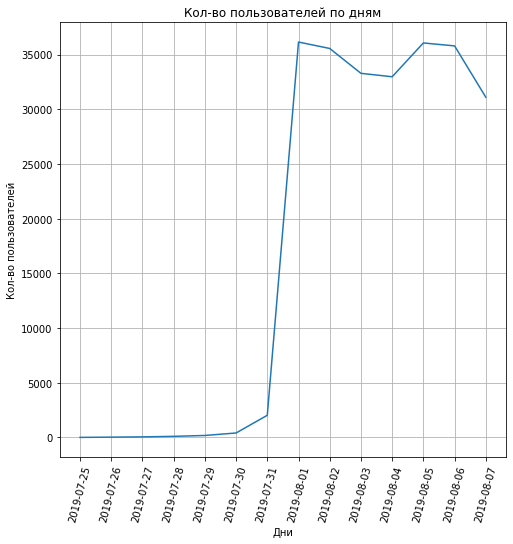

In [14]:
plt.figure(figsize=(8, 8))
plt.title("Кол-во пользователей по дням")
plt.plot(data.groupby('date').agg({'user_id':'count'}))
plt.xticks(rotation=75)
plt.xlabel("Дни")
plt.ylabel("Кол-во пользователей")
plt.grid(True)
plt.show()

Распределение логов во времени показывает, что до августа данных почти не было. Проверим, насколько критично будет их удаление.

In [15]:
data = data.loc[data['date'] >= '2019-08-01']
data.info() #мы потеряли около 3к записей, что для нас не критично

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      240887 non-null  object        
 1   user_id         240887 non-null  int64         
 2   event_datetime  240887 non-null  datetime64[ns]
 3   group           240887 non-null  int64         
 4   date            240887 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.0+ MB


In [16]:
print('При удалении данных до 1 августа мы потеряли {:.2%} данных'.format(1 - (240887 / 243713)))

При удалении данных до 1 августа мы потеряли 1.16% данных


Есть наименнее распространенный тип события "Tutorial". Он не относится напрямую к воронке продаж, так что такие записи исключим:

In [17]:
# также, сразу удалим записи с типом события туториал
data = data.loc[data['event_name']!='Tutorial']

In [18]:
# проверим, все ли тестируемые группы представлены
data.group.value_counts()

248    84213
246    78985
247    76684
Name: group, dtype: int64

##### Вывод:
- Имеем данные за 2 недели: с 25 июля 2019 по 7 августа 2019.
- Однако при этом на гистограмме наблюдается странная картина: ло 1 августа данных почти не было. То есть фактически мы располагаем данными только за одну неделю. Прочими можем пренебречь и потерять около 3000 записей.
- Всего 7551 пользователей было за этот период.
- В среднем на одного пользователя приходилось 20 событий.
- Всего типов событий 5. От показа главного экрана до показа страницы с сообщением об успешной оплате. Это наша будущая воронка.
- Также есть наименнее распространенный тип события "Tutorial". Он не относится напрямую к воронке продаж, так что такие записи исключили.
- В логах есть представители всех тестируемых групп.

## Воронка событий

In [19]:
event_name_grouped = (data.groupby('event_name').agg({'user_id':'nunique'})).sort_values(
    by='user_id',ascending=False)
event_name_grouped = event_name_grouped.reset_index()
event_name_grouped.columns=['event_name', 'events_number']
event_name_grouped#.reset_index()

,event_name,events_number
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


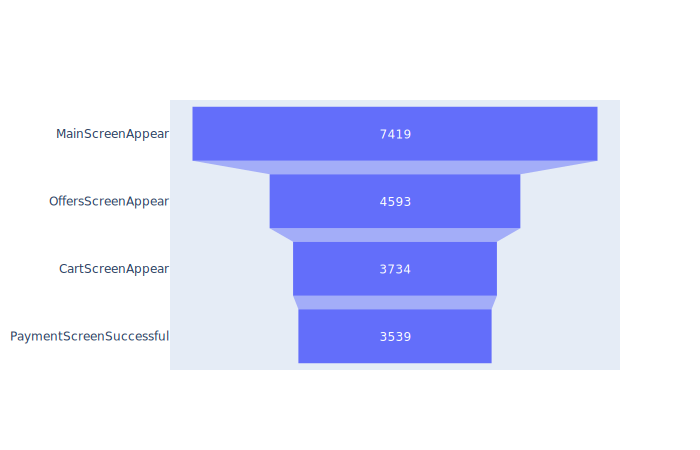

In [20]:
# построим воронку
fig = go.Figure(go.Funnel(
    y = event_name_grouped['event_name'],
    x = event_name_grouped['events_number']
    ))
fig.show(renderer="svg")

##### Вывод:
Из графика выше видим, что основная часть событий (38%) - это показ главного экрана. На этапе оффера у нас остается 61.9% от тех, кто увидел главный экран. На этапе экрана с оплатой остается 50.3%, и до конца (т.е. успешно завершают оплату) добираются 47.7%.

Больше всего пользователей мы теряем на этапе перехода от главного экрана к офферу. Возможно пользователям что-то не понравилось на сайте или они туда попали по ошибке (скажем, случайно кликнули по нашему баннеру).

## Изучим результаты эксперимента

Для успешного А/А теста разница в количестве пользователей между тестируемыми группами должна быть <span style="color: red">НЕ</span> слишком большой. Проверим.

In [21]:
groups_count = ((data.group.value_counts()).to_frame()).reset_index()
groups_count.columns = ['group', 'events_number']
groups_count

,group,events_number
0,248,84213
1,246,78985
2,247,76684


In [22]:
# сравним контрольные группы 246 и 247
76684 / 78985 - 1

-0.02913211369247326

Группы отличаются на 3%. Это ок.
Перейдем непосредственно к тестам.

In [23]:
# сделаем срез по каждой группе теста
group246 = data.query('group == 246')
group247 = data.query('group == 247')
group248 = data.query('group == 248')

#посмотрим кол-во действий на каждом этапе в каждой отдельной группе
group246 = (group246.groupby(['event_name'], as_index=False).agg({'user_id':'nunique'})[['event_name','user_id']]).sort_values(by=
                                                                                                                              'user_id',
                                                                                                                              ascending=False)
group247 = group247.groupby(['event_name'], as_index=False).agg({'user_id':'nunique'})[['event_name','user_id']].sort_values(by=
                                                                                                                              'user_id',
                                                                                                                              ascending=False)
group248 = group248.groupby(['event_name'], as_index=False).agg({'user_id':'nunique'})[['event_name','user_id']].sort_values(by=
                                                                                                                              'user_id',
                                                                                                                              ascending=False)
group246

,event_name,user_id
1,MainScreenAppear,2450
2,OffersScreenAppear,1542
0,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200


In [24]:
# выведем воронку конверсии из показа главного экрана для всех трех групп
test_groups = [group246, group247, group248]
for gr in test_groups:
    gr['share'] = gr['user_id'].map(lambda x: x/gr['user_id'].max())
    print(gr)
    print()
    print()
    


                event_name  user_id     share
1         MainScreenAppear     2450  1.000000
2       OffersScreenAppear     1542  0.629388
0         CartScreenAppear     1266  0.516735
3  PaymentScreenSuccessful     1200  0.489796


                event_name  user_id     share
1         MainScreenAppear     2476  1.000000
2       OffersScreenAppear     1520  0.613893
0         CartScreenAppear     1238  0.500000
3  PaymentScreenSuccessful     1158  0.467690


                event_name  user_id     share
1         MainScreenAppear     2493  1.000000
2       OffersScreenAppear     1531  0.614120
0         CartScreenAppear     1230  0.493381
3  PaymentScreenSuccessful     1181  0.473726




Видим, что конверсии с главного экрана в другие события у всех трех групп примерно равны. Теперь посмотрим на стат значимость

In [25]:
#ф-ция для z-теста

def z_test(n1, x1, n2, x2, alpha):
    p1 = x1/n1
    p2 = x2/n2
    p = (p1*n1 + p2*n2)/(n1+n2)
    SE = np.sqrt(p*(1-p)*(1/n1 + 1/n2)) #стандартная ошибка
    m=SE*st.norm.ppf(1-alpha/2)
    z_stat = (p1-p2)/SE
    p=st.norm.cdf(np.abs(z_stat))
    return 2*(1-p)

H0: В группах А1 и А2 конверсия в событие различна

Н1: В группах А1 и А2 конверсия в событие не отличается
.  
- Для проверки гипотез возьмем базовый уровень значимости равный 0.05. Так как тест будет множественный, используем поправку Бонферрони и поделим уровень значимости ɑ на число гипотез:


In [26]:
# Проведем тест между группами А 
events1 = data.copy()
events1 = events1.loc[events1['group']!=248]
events1['group'] = events1['group'].astype(str).str.replace('246', 'A1').str.replace('247', 'A2')
# кол-во уинков
totals1 = events1.groupby('group').agg({'user_id':'nunique'})['user_id']
counts1 = events1.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
# корректируем alpha поправкой Бонферрони
counts1['alpha'] = 0.05 / (counts1.shape[0]*2)
counts1['p-value'] = counts1.apply(lambda x: z_test(totals1['A1'], x['A1'], totals1['A2'], x['A2'], counts1['alpha']), axis=1)
counts1

group,A1,A2,alpha,p-value
event_name,,,,
CartScreenAppear,1266,1238,0.00625,0.228676
MainScreenAppear,2450,2476,0.00625,0.752670
OffersScreenAppear,1542,1520,0.00625,0.247861
PaymentScreenSuccessful,1200,1158,0.00625,0.114466


In [27]:
counts1['test_summary'] = 'Отвергаем Н0' 
counts1.loc[counts1['p-value'] < counts1['alpha'], 'test_summary'] == 'Не можем отвергнуть Н0'
counts1

group,A1,A2,alpha,p-value,test_summary
event_name,,,,,
CartScreenAppear,1266,1238,0.00625,0.228676,Отвергаем Н0
MainScreenAppear,2450,2476,0.00625,0.752670,Отвергаем Н0
OffersScreenAppear,1542,1520,0.00625,0.247861,Отвергаем Н0
PaymentScreenSuccessful,1200,1158,0.00625,0.114466,Отвергаем Н0


##### Вывод: 
Значимых стат различий между группами А1 и А2 не обнаружено.

Теперь проведем АВ тест. Аналогично используем поправку Бонферрони для проведения множественного теста. Сравнивать будем объединенную группу А1 и А2 (примем, что они эквивалентны) и группу В:

In [28]:
# сравним группы А и В

events = data.copy()
events['group'] = events['group'].astype(str).str.replace('246|247', 'A').str.replace('248', 'B')
# кол-во уинков
totals = events.groupby('group').agg({'user_id':'nunique'})['user_id']
counts = events.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
# корректируем alpha поправкой Бонферрони
counts['alpha'] = 0.05 / (counts.shape[0]*2)
counts['p-value'] = counts.apply(lambda x: z_test(totals['A'], x['A'], totals['B'], x['B'], counts['alpha']), axis=1)
counts

group,A,B,alpha,p-value
event_name,,,,
CartScreenAppear,2504,1230,0.00625,0.186836
MainScreenAppear,4926,2493,0.00625,0.348668
OffersScreenAppear,3062,1531,0.00625,0.445827
PaymentScreenSuccessful,2358,1181,0.00625,0.610792


H0: В группах А и В конверсия в событие различна

Н1: В группах А и В конверсия в событие не отличается

In [29]:
counts['test_summary'] = 'Отвергаем Н0' 
counts.loc[counts['p-value'] < counts['alpha'], 'test_summary'] == 'Не можем отвергнуть Н0'
counts

group,A,B,alpha,p-value,test_summary
event_name,,,,,
CartScreenAppear,2504,1230,0.00625,0.186836,Отвергаем Н0
MainScreenAppear,4926,2493,0.00625,0.348668,Отвергаем Н0
OffersScreenAppear,3062,1531,0.00625,0.445827,Отвергаем Н0
PaymentScreenSuccessful,2358,1181,0.00625,0.610792,Отвергаем Н0


##### Вывод:
Значимых стат различий между группами А и В не обнаружено.

## Вывод:
В рамках работы были использованы данные месячного тестирования нового шрифта в приложении. Была проведена техническая предобработка и очистка данных (в т.ч. были очищены данные июля за их незначительным количеством).

Была построена воронка событий для всех событий, в результате чего мы выяснили, что до финального этапа воронки (оплаты) в целом доходит 47.7% посетителей.

Для большей достоверных результатов перед А/В тестированием было проведено А/А тестирование, которое не выявило значимых различий между группами. А/В тест так же не показал различий между тестируемыми сегментами.

Таким образом, Результаты теста не выявили преимуществ использования нового шрифта. В рамках теста на конверсию это изменение не повлияло.